# Feature Engineering and Modeling

In [1]:
# import libraries
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
# import datasets
cases_df = pd.read_csv('../clean_data/Cases_Normalized_per_100k.csv')
cases_df.head()

,county,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,date,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,population,confirmedper100k,newlyconfirmedper100k,deathper100k,newdeath100k,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,7dayrollingavg_newlyconfirmed_rawnumber,7dayrollingavg_newdeath_rawnumber
0,Alameda,29.0,0.0,29,0,2020-03-18,0.019,0.008,0.055,0.123,0.795,1671329,1.735146,1.735146,0.000000,0.000000,NaN,NaN,NaN,NaN
1,Alameda,36.0,0.0,7,0,2020-03-19,0.019,0.008,0.055,0.123,0.795,1671329,2.153974,0.418828,0.000000,0.000000,NaN,NaN,NaN,NaN
2,Alameda,42.0,0.0,6,0,2020-03-20,0.019,0.008,0.055,0.123,0.795,1671329,2.512970,0.358996,0.000000,0.000000,NaN,NaN,NaN,NaN
3,Alameda,62.0,0.0,20,0,2020-03-21,0.019,0.008,0.055,0.123,0.795,1671329,3.709623,1.196652,0.000000,0.000000,NaN,NaN,NaN,NaN
4,Alameda,72.0,1.0,10,1,2020-03-22,0.019,0.008,0.055,0.123,0.795,1671329,4.307949,0.598326,0.059833,0.059833,NaN,NaN,NaN,NaN


In [3]:
cases_df.describe()

,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,population,confirmedper100k,newlyconfirmedper100k,deathper100k,newdeath100k,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,7dayrollingavg_newlyconfirmed_rawnumber,7dayrollingavg_newdeath_rawnumber
count,1.812400e+04,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,1.812400e+04,18124.000000,18124.000000,18124.000000,18124.000000,17776.000000,1.777600e+04,17776.000000,17776.000000
mean,1.327444e+04,210.774443,173.013187,2.048003,0.032279,0.030699,0.063650,0.158545,0.714792,6.823606e+05,1542.530785,20.284986,19.606417,0.210988,20.232502,2.081917e-01,172.290086,2.001583
std,5.201773e+04,852.430551,814.985729,11.017366,0.028533,0.026178,0.033898,0.040410,0.092762,1.456208e+06,2084.332897,43.944282,28.624650,0.831238,31.417552,4.040341e-01,775.800926,9.438015
min,0.000000e+00,0.000000,-1157.000000,-16.000000,0.001000,0.000000,0.004000,0.058000,0.482000,1.129000e+03,0.000000,-74.546183,0.000000,-5.543545,-6.977150,-7.919349e-01,-1.142857,-1.428571
25%,9.400000e+01,1.000000,1.000000,0.000000,0.015000,0.013000,0.040000,0.134000,0.661000,4.590500e+04,99.646385,0.606875,1.002456,0.000000,2.049615,1.522592e-15,2.000000,0.000000
50%,1.044000e+03,15.000000,14.000000,0.000000,0.023000,0.023000,0.058000,0.156000,0.737000,1.928430e+05,711.532789,6.700781,8.138623,0.000000,8.310360,5.983262e-02,18.285714,0.142857
75%,8.147250e+03,114.000000,85.000000,0.000000,0.043000,0.043000,0.084000,0.186000,0.786000,7.621480e+05,2248.121154,22.165620,27.829294,0.000000,24.251025,2.301092e-01,89.464286,1.000000
max,1.048757e+06,15260.000000,28549.000000,318.000000,0.140000,0.135000,0.162000,0.276000,0.889000,1.003911e+07,15791.711641,1860.053144,272.052534,27.717723,566.793296,6.335479e+00,15711.142857,241.285714


In [4]:
# convert date to datetime
cases_df['date'] = pd.to_datetime(cases_df['date'])

In [5]:
# drop no longer needed columns
cases_df.drop(['totalcountconfirmed', 'totalcountdeaths', 'newcountconfirmed',
              'newcountdeaths', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 
              'ALWAYS', 'deathper100k', 'newdeath100k', 'confirmedper100k', 'population',
               'newlyconfirmedper100k' ,'7dayrollingavg_newlyconfirmed_rawnumber', '7dayrollingavg_newdeath_rawnumber'], 
             axis = 1, inplace = True)
cases_df.head()

,county,date,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath
0,Alameda,2020-03-18,NaN,NaN
1,Alameda,2020-03-19,NaN,NaN
2,Alameda,2020-03-20,NaN,NaN
3,Alameda,2020-03-21,NaN,NaN
4,Alameda,2020-03-22,NaN,NaN


In [6]:
# bring in hospital data
hospitals_df = pd.read_csv('../clean_data/hospitals_by_county.csv')
hospitals_df.head()

,county,todays_date,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds
0,Plumas,2020-03-29,0.0,1.0,1.0,NaN,0.0,1.0,NaN
1,Tehama,2020-03-29,0.0,0.0,0.0,308.0,0.0,0.0,2.0
2,Glenn,2020-03-29,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,Mono,2020-03-29,0.0,1.0,1.0,308.0,0.0,0.0,2.0
4,Marin,2020-03-29,7.0,13.0,20.0,493.0,2.0,6.0,11.0


In [7]:
# convert to datetime
hospitals_df['todays_date'] = pd.to_datetime(hospitals_df['todays_date'])

In [8]:
# drop unncessary columns
hospitals_df.drop(['hospitalized_covid_confirmed_patients', 'hospitalized_suspected_covid_patients', 
                   'icu_covid_confirmed_patients', 'icu_suspected_covid_patients'],
                 axis = 1, inplace = True)
hospitals_df.head()

,county,todays_date,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
0,Plumas,2020-03-29,1.0,NaN,NaN
1,Tehama,2020-03-29,0.0,308.0,2.0
2,Glenn,2020-03-29,0.0,NaN,NaN
3,Mono,2020-03-29,1.0,308.0,2.0
4,Marin,2020-03-29,20.0,493.0,11.0


In [9]:
cases_hosp_df = cases_df.merge(hospitals_df, how = 'inner', left_on = ['county','date'], right_on = ['county', 'todays_date'])
cases_hosp_df.head()

,county,date,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,todays_date,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
0,Alameda,2020-03-29,1.153915,0.042738,2020-03-29,127.0,2725.0,119.0
1,Alameda,2020-03-30,1.384698,0.051285,2020-03-30,148.0,3283.0,146.0
2,Alameda,2020-03-31,1.478721,0.042738,2020-03-31,150.0,1857.0,77.0
3,Alameda,2020-04-01,1.307770,0.042738,2020-04-01,128.0,2456.0,106.0
4,Alameda,2020-04-02,1.478721,0.051285,2020-04-02,133.0,2580.0,112.0


In [10]:
# do a group by so we can create predictions per county
county_df = cases_hosp_df.groupby(['county', 'date']).mean()

In [11]:
county_df.index.get_level_values('county').unique()[0]

'Alameda'

In [12]:
# start by analyzing LA County
county_df.loc['Los Angeles']

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
date,,,,,
2020-03-29,2.468916,0.048382,1621.0,7394.0,345.0
2020-03-30,2.957007,0.056920,1878.0,9688.0,456.0
2020-03-31,3.369679,0.059766,1952.0,9460.0,445.0
2020-04-01,3.951689,0.079688,2071.0,10431.0,492.0
2020-04-02,4.219214,0.086803,2088.0,10349.0,488.0
...,...,...,...,...,...
2021-01-20,110.458032,2.033476,7413.0,19392.0,236.0
2021-01-21,97.337912,2.002170,7226.0,19411.0,274.0
2021-01-22,88.508157,1.999324,7014.0,19377.0,281.0


In [13]:
county_df.loc['Los Angeles']

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
date,,,,,
2020-03-29,2.468916,0.048382,1621.0,7394.0,345.0
2020-03-30,2.957007,0.056920,1878.0,9688.0,456.0
2020-03-31,3.369679,0.059766,1952.0,9460.0,445.0
2020-04-01,3.951689,0.079688,2071.0,10431.0,492.0
2020-04-02,4.219214,0.086803,2088.0,10349.0,488.0
...,...,...,...,...,...
2021-01-20,110.458032,2.033476,7413.0,19392.0,236.0
2021-01-21,97.337912,2.002170,7226.0,19411.0,274.0
2021-01-22,88.508157,1.999324,7014.0,19377.0,281.0


In [14]:
la_df = county_df.loc['Los Angeles'].tail(110)
features = ['hospitalized_covid_patients']
X = la_df[features]
y = la_df[['7dayrollingavg_newlyconfirmed']].values

In [15]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.2)

In [16]:
# scale our data
mms = MinMaxScaler()
X_train_sc = mms.fit_transform(X_train)
X_test_sc = mms.transform(X_test)

In [17]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 21,  batch_size = 32)

In [18]:
# Create test sequences
batch_x, batch_y = train_sequences[0]

In [19]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 21,  batch_size = 32)

In [20]:
input_shape = train_sequences[0][0][0].shape

In [21]:
# Design RNN
model = Sequential()
model.add(LSTM(128, input_shape = (input_shape), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences = True))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'swish', kernel_regularizer = l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(16, activation = 'swish', kernel_regularizer = l2(0.01)))
model.add(Dense(1))

In [22]:
model.compile(optimizer=Adam(lr = 0.005), loss = 'mae')
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, mode = 'auto')

In [23]:
history = model.fit(train_sequences, validation_data = (test_sequences), epochs = 200, verbose = 0,callbacks = [early_stop] )

Epoch 00016: early stopping


In [24]:
print(history.history['loss'][-1])
print(history.history['val_loss'][-1])

52.102691650390625
21.032548904418945


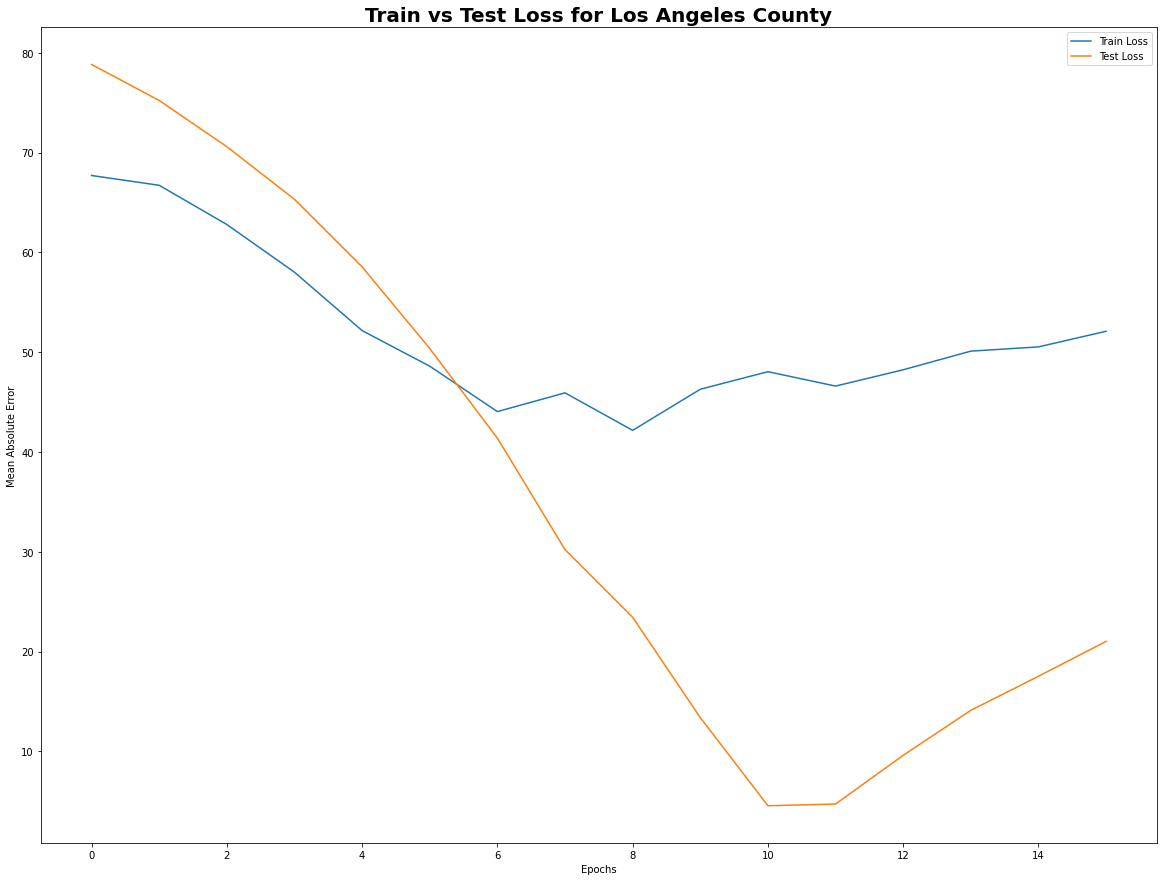

In [25]:
plt.figure(figsize=(20,15))
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.title('Train vs Test Loss for Los Angeles County', fontsize = 20, fontweight = 'bold')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.savefig('../images/train_test_loss_la_county.png');

In [26]:
# generate predictions
future_pred_count = 21
future = []
batch = X_test_sc[-future_pred_count:].reshape((1, future_pred_count, 1))
model.predict(batch)[0].shape

for i in range(future_pred_count):
    pred = model.predict(batch)[0]
    future.append(pred)
    batch = np.append(batch[:, 1:, :], [[pred[i]]] , axis = 1)

In [27]:
dates = [la_df.index[-1] + pd.tseries.offsets.DateOffset(days = x) for x in range(0, 22)]
future_date = pd.DataFrame(index = dates[1:], columns = X.columns)
future_date.head()

,hospitalized_covid_patients
2021-01-25,NaN
2021-01-26,NaN
2021-01-27,NaN
2021-01-28,NaN
2021-01-29,NaN


In [28]:
future[0]

array([[61.33975 ],
       [95.84857 ],
       [99.41763 ],
       [99.90123 ],
       [99.981735],
       [99.99064 ],
       [99.99064 ],
       [99.99064 ],
       [99.99064 ],
       [99.99064 ],
       [99.99064 ],
       [99.99064 ],
       [99.99064 ],
       [99.99064 ],
       [99.99064 ],
       [99.99064 ],
       [99.99064 ],
       [99.99064 ],
       [99.99064 ],
       [99.99064 ],
       [99.99064 ]], dtype=float32)

In [29]:
df_predict = pd.DataFrame(future[0], index = future_date[-21:].index, columns = ['Prediction'])
df_predict.head()

,Prediction
2021-01-25,61.339748
2021-01-26,95.848572
2021-01-27,99.417633
2021-01-28,99.901230
2021-01-29,99.981735


In [30]:
df_test = pd.concat([la_df, df_predict], axis = 1)
df_test

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds,Prediction
2020-10-07,7.540511,0.189260,1077.0,20087.0,958.0,NaN
2020-10-08,7.470784,0.165069,1059.0,20130.0,920.0,NaN
2020-10-09,10.109038,0.163646,1044.0,20053.0,941.0,NaN
2020-10-10,10.450560,0.179299,1053.0,19986.0,950.0,NaN
2020-10-11,10.484712,0.176453,1045.0,19844.0,999.0,NaN
...,...,...,...,...,...,...
2021-02-10,NaN,NaN,NaN,NaN,NaN,99.990639
2021-02-11,NaN,NaN,NaN,NaN,NaN,99.990639
2021-02-12,NaN,NaN,NaN,NaN,NaN,99.990639
2021-02-13,NaN,NaN,NaN,NaN,NaN,99.990639


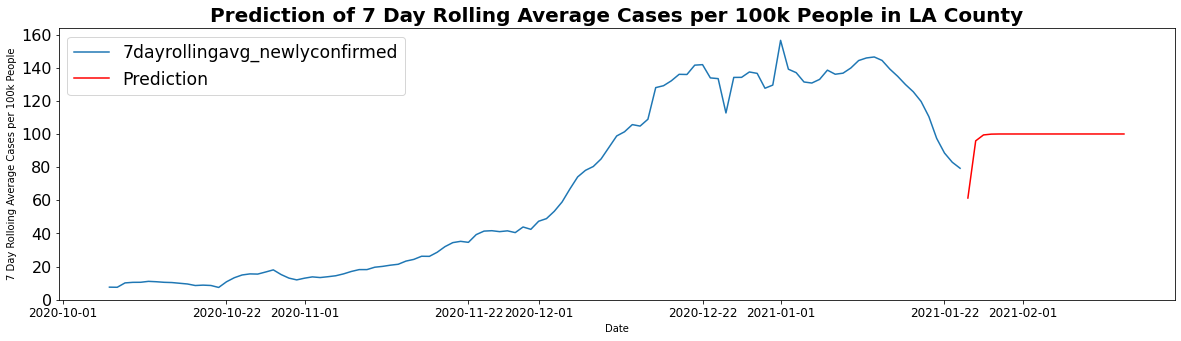

<Figure size 432x288 with 0 Axes>

In [34]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['7dayrollingavg_newlyconfirmed'])
plt.plot(df_test.index, df_test['Prediction'], color = 'r')
plt.legend(['7dayrollingavg_newlyconfirmed', 'Prediction'], loc = 'best', fontsize = 'xx-large')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 16)
plt.xlabel('Date')
plt.ylabel('7 Day Rolloing Average Cases per 100k People')
plt.title('Prediction of 7 Day Rolling Average Cases per 100k People in LA County', fontsize = 20, fontweight = 'bold')
plt.show()
plt.savefig('../images/rolling_7_day_prediction.png');

In [35]:
# create a function to generate predictions for every county
def pred_model(df):
    X = df[['hospitalized_covid_patients']]
    y = df[['7dayrollingavg_newlyconfirmed']].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.4)
    mms = MinMaxScaler() # use MinMaxScaler as we are dealing with purely positive values
    X_train_sc = mms.fit_transform(X_train)
    X_test_sc = mms.transform(X_test)
    
    # Create training sequences
    train_sequences = TimeseriesGenerator(X_train_sc, y_train, length = 21,  batch_size = 128)
    
    # Create test sequences
    batch_x, batch_y = train_sequences[0]
    test_sequences = TimeseriesGenerator(X_test_sc, y_test, length = 21,  batch_size = 128)
    input_shape = train_sequences[0][0][0].shape
    
    # Design RNN
    model = Sequential()
    model.add(LSTM(60, input_shape = (input_shape), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation = 'swish', kernel_regularizer = l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation = 'swish', kernel_regularizer = l2(0.01)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr = 0.005), loss = 'mae')
    model.fit(train_sequences, validation_data = (test_sequences), epochs = 1000, verbose = 0)
    
    future_pred_count = 21
    future = []
    batch = X_test_sc[-future_pred_count:].reshape((1, future_pred_count, 1))
    model.predict(batch)[0].shape

    for i in range(future_pred_count):
        pred = model.predict(batch)[0]
        future.append(pred)
        batch = np.append(batch[:, 1:, :], [[pred[i]]] , axis = 1)
        
    dates = [la_df.index[-1] + pd.tseries.offsets.DateOffset(days = x) for x in range(0, 22)]
    future_date = pd.DataFrame(index = dates[1:], columns = X.columns)
    future_date.head()
    
    df_predict = pd.DataFrame(future[0], index = future_date[-21:].index, columns = ['Prediction'])
    df_test = pd.concat([df, df_predict], axis = 1)
    
    return df_test

In [36]:
# generate predictions for all 58 counties
todays_date = datetime.datetime.now().date()
index = pd.date_range(todays_date-datetime.timedelta(400), periods = 1, freq = 'D')
pred_df = pd.DataFrame(index = index, columns = df_test.columns)

for i in county_df.index.get_level_values('county').unique():
    model_df = county_df.loc[i].tail(120)
    prediction_df = pred_model(model_df)
    prediction_df['County'] = i
    pred_df = pred_df.append(prediction_df)
    
pred_df.head()

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds,Prediction,County
2019-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-27,5.572982,0.273521,113.0,2364.0,124.0,NaN,Alameda
2020-09-28,5.402031,0.273521,114.0,2368.0,125.0,NaN,Alameda
2020-09-29,5.419126,0.153855,125.0,2390.0,126.0,NaN,Alameda
2020-09-30,4.726777,0.145308,116.0,2415.0,121.0,NaN,Alameda


In [37]:
pred_df.tail()

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds,Prediction,County
2021-02-10,NaN,NaN,NaN,NaN,NaN,60.805000,Yuba
2021-02-11,NaN,NaN,NaN,NaN,NaN,60.805328,Yuba
2021-02-12,NaN,NaN,NaN,NaN,NaN,60.804646,Yuba
2021-02-13,NaN,NaN,NaN,NaN,NaN,60.798901,Yuba
2021-02-14,NaN,NaN,NaN,NaN,NaN,60.789745,Yuba


In [38]:
pred_df.drop(index = pred_df.index[0], axis = 0, inplace = True)

In [39]:
pred_df['7dayrollingavg_newlyconfirmed'].fillna(pred_df['Prediction'], inplace = True)

In [40]:
pred_df.head()

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds,Prediction,County
2020-09-27,5.572982,0.273521,113.0,2364.0,124.0,NaN,Alameda
2020-09-28,5.402031,0.273521,114.0,2368.0,125.0,NaN,Alameda
2020-09-29,5.419126,0.153855,125.0,2390.0,126.0,NaN,Alameda
2020-09-30,4.726777,0.145308,116.0,2415.0,121.0,NaN,Alameda
2020-10-01,4.367782,0.196593,130.0,2433.0,101.0,NaN,Alameda


In [41]:
pred_df[pred_df['County'] == 'San Francisco'][110:140]

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds,Prediction,County
2021-01-15,35.586710,0.372721,244.0,2123.0,53.0,NaN,San Francisco
2021-01-16,34.760243,0.340310,246.0,2131.0,57.0,NaN,San Francisco
2021-01-17,33.787928,0.340310,247.0,2127.0,67.0,NaN,San Francisco
2021-01-18,33.334181,0.453747,243.0,2127.0,72.0,NaN,San Francisco
2021-01-19,31.940531,0.437542,247.0,2106.0,69.0,NaN,San Francisco
2021-01-20,29.201845,0.502362,243.0,2122.0,55.0,NaN,San Francisco
2021-01-21,25.944591,0.599594,223.0,2118.0,52.0,NaN,San Francisco
2021-01-22,23.546216,0.550978,214.0,2122.0,52.0,NaN,San Francisco
2021-01-23,23.578626,0.388926,201.0,2133.0,49.0,NaN,San Francisco
2021-01-24,23.011443,0.632004,197.0,2103.0,57.0,NaN,San Francisco


In [42]:
export_df = pred_df[['7dayrollingavg_newlyconfirmed', 'County']]
export_df.head()

,7dayrollingavg_newlyconfirmed,County
2020-09-27,5.572982,Alameda
2020-09-28,5.402031,Alameda
2020-09-29,5.419126,Alameda
2020-09-30,4.726777,Alameda
2020-10-01,4.367782,Alameda


In [43]:
export_df.to_csv('../clean_data/predictions.csv')